In [209]:
import pandas as pd
df = pd.read_pickle('Recipes_data_Whole_Sim_Ingrs.pkl')

In [210]:
df_exploded = df.explode('Ingredients')
df_exploded['Value'] = 1
df_pivot = df_exploded.groupby(['Title', 'Ingredients'])['Value'].sum().unstack(fill_value=0).reset_index()
df_pivot.reset_index(inplace=True)
df_pivot.columns

Index(['index', 'Title', '', 'Almond Red Sauce', 'Apple Cider Sauce',
       'Arroz a la Mexicana Perfect Mexican Rice', 'Balsamic Glaze',
       'Balti Masala Spice Mix', 'Barbs Special Sweet Breads Part I',
       'Basic Pte Choux Quick Change Pastry Puffs',
       ...
       'yeast cakes', 'yellow corn', 'yellow crookneck squash',
       'yellow hominy', 'yellow summer squash', 'yerba buena', 'yogurt',
       'yucca', 'zucchini', 'zwieback crumbs'],
      dtype='object', name='Ingredients', length=1617)

In [211]:
df_boolean = df_pivot.astype(bool)
df_encoded = pd.get_dummies(df_boolean.drop(['Title','index'], axis=1))
df_encoded

Ingredients,,Almond Red Sauce,Apple Cider Sauce,Arroz a la Mexicana Perfect Mexican Rice,Balsamic Glaze,Balti Masala Spice Mix,Barbs Special Sweet Breads Part I,Basic Pte Choux Quick Change Pastry Puffs,Ben Jerrys Sweet Ice Cream Base,Chaat Powder Masala,...,yeast cakes,yellow corn,yellow crookneck squash,yellow hominy,yellow summer squash,yerba buena,yogurt,yucca,zucchini,zwieback crumbs
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7805,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
7806,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7807,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
7808,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [212]:
columns_to_exclude = ['salt','sugar','water', 'vegetable oil']
filtered_columns = [col for col in df_encoded.columns if col not in columns_to_exclude]
df_encoded = df_encoded[filtered_columns]

## Apriori 

In [213]:
from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemsets = apriori(df_encoded, min_support=0.02, use_colnames=True)
len(frequent_itemsets)

298

In [227]:
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.2)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Parmesan cheese),(black pepper),0.055186,0.228809,0.022791,0.412993,1.804967,0.010164,1.313768,0.472022
1,(Parmesan cheese),(garlic),0.055186,0.285019,0.027785,0.503480,1.766478,0.012056,1.439985,0.459246
2,(Parmesan cheese),(olive oil),0.055186,0.137260,0.020230,0.366589,2.670767,0.012656,1.362055,0.662115
3,(allpurpose flour),(baking powder),0.223047,0.118438,0.087708,0.393226,3.320104,0.061291,1.452868,0.899417
4,(baking powder),(allpurpose flour),0.118438,0.223047,0.087708,0.740541,3.320104,0.061291,2.994505,0.792689
...,...,...,...,...,...,...,...,...,...,...
449,"(allpurpose flour, vanilla bean)","(butter, eggs)",0.065045,0.091805,0.026761,0.411417,4.481408,0.020789,1.543020,0.830902
450,"(butter, eggs)","(allpurpose flour, vanilla bean)",0.091805,0.065045,0.026761,0.291492,4.481408,0.020789,1.319612,0.855385
451,"(butter, vanilla bean)","(allpurpose flour, eggs)",0.046223,0.133547,0.026761,0.578947,4.335167,0.020588,2.057827,0.806612
452,"(eggs, vanilla bean)","(allpurpose flour, butter)",0.079129,0.092446,0.026761,0.338188,3.658235,0.019445,1.371317,0.789084


In [223]:
import numpy as np

def recommend_recipes(ingredients, rules):
    relevant_rules = rules[rules['antecedents'].apply(lambda x: set(ingredients).issubset(set(x)))]
    relevant_rules = relevant_rules.sort_values(by='confidence', ascending=False)

    #print(len(relevant_rules['consequents']))
    top_rules = relevant_rules.iloc[0:3]
    recommended_ingredients = list(top_rules['consequents'])

    unique_ingredients = set()
    for item in recommended_ingredients:
        unique_ingredients.update(item)
    
    return list(unique_ingredients)


user_input_ingredients = ['garlic','tomatoes']

recommended_ingredients = []
for ing in user_input_ingredients:
    rins = recommend_recipes([ing], rules)
    for i in rins:
        if(i not in recommended_ingredients and i not in user_input_ingredients):
            recommended_ingredients.append(i)

print('Recommended Ingredients:', recommended_ingredients)

Recommended Ingredients: ['ginger', 'onions']


In [224]:
from itertools import combinations

combs = []
print(recommended_ingredients)
for j in range(1, len(recommended_ingredients) + 1):
    combs.extend(list(combinations(recommended_ingredients, j)))

recoms = [user_input_ingredients]
for i in combs:
    recoms.append(user_input_ingredients + list(i))

recoms

['ginger', 'onions']


[['garlic', 'tomatoes'],
 ['garlic', 'tomatoes', 'ginger'],
 ['garlic', 'tomatoes', 'onions'],
 ['garlic', 'tomatoes', 'ginger', 'onions']]

In [225]:
recommended_recipes = pd.DataFrame()
for rc in recoms:
    recommended_recipes = pd.concat([recommended_recipes, df[df['Ingredients'].apply(lambda x: all(ingredient in x for ingredient in rc))]])


recommended_recipes= recommended_recipes.reset_index(drop=True)
recommended_recipes

,Title,Ingredients,Type
0,Quinoa Stuffed Bell Peppers,"[black olives, quinoa, spaghetti sauce, beans,...",Diabetic
1,Bulgur Wheat and Vegetables,"[cracked wheat bulgur, green bell peppers, zuc...",Diabetic
2,Chicken and Broccoli Skillet,"[chicken, broccoli slaw, lemon pepper, garlic,...",Diabetic
3,Quick Chicken Cacciatore,"[chicken, green bell peppers, oregano, cornsta...",Diabetic
4,Spaghetti Squash Casserole,"[garlic, olive oil, tomatoes, green onions, mo...",Diabetic
...,...,...,...
1256,Apple-Lovage Chutney,"[red wine vinegar, lovage, apples, sugar, swee...",Side Dish
1257,Exotic Spiced Pea Pilaf,"[garlic, tomatoes, cinnamon, ginger, yogurt, c...",Side Dish
1258,Channa Masala,"[corander, cumin seeds, lemon, chile pepper, g...",Side Dish
1259,Goan Ginger-Scented Tomato and Cabbage Soup,"[stock, carrots, ti leaves, olive oil, garlic,...",Appetizers


In [104]:
np.unique(recommended_recipes.Type)

array(['Africa & Middle East', 'American', 'Appetizers', 'Asian',
       'Breakfast and Brunch', 'Diabetic', 'European', 'Gluten-Free',
       'Indian', 'Low-Carb', 'Low-Fat', 'Main Dish', 'Mexican',
       'Side Dish', 'Standard'], dtype=object)

In [105]:
Ings = user_input_ingredients + recommended_ingredients
Ings

['garlic', 'tomatoes', 'ginger', 'onions']

In [114]:
import pickle

with open('sgd_classifier_Cuisines.pkl', 'rb') as model_file:
     sgd_classifier_Cuisines = pickle.load(model_file)

with open('sgd_classifier_Course.pkl', 'rb') as model_file:
     sgd_classifier_Course = pickle.load(model_file)

with open('sgd_classifier_Dietary.pkl', 'rb') as model_file:
     sgd_classifier_Dietary = pickle.load(model_file)

In [197]:
Ings_str = ' '.join(Ings)
classes =[]

In [198]:
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_pickle('Recipes_data_Cuisines_Sim_Ingrs.pkl')
df['Ingredients'] = df['Ingredients'].apply(lambda x: ' '.join(x))
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Ingredients'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
Ings_str = ' '.join(Ings)

tfidf_features = tfidf_vectorizer.transform([Ings_str])

class_probabilities = sgd_classifier_Cuisines.predict_proba(tfidf_features)

top_indices = [i for i, prob in enumerate(class_probabilities[0]) if prob > 0.25]

# Get the corresponding class labels
top_classes = sgd_classifier_Cuisines.classes_[top_indices]

if len(top_classes)==0:
    top_indices = class_probabilities.argsort()[0][-1:][::-1]
    top_classes = sgd_classifier_Cuisines.classes_[top_indices]

classes.extend(top_classes)
top_classes

/Users/harishneelam/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but SGDClassifier was fitted with feature names



array(['Asian', 'Indian'], dtype='<U20')

In [199]:
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_pickle('Recipes_data_Dietary_Sim_Ingrs.pkl')
df['Ingredients'] = df['Ingredients'].apply(lambda x: ' '.join(x))
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Ingredients'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
Ings_str = ' '.join(Ings)

tfidf_features = tfidf_vectorizer.transform([Ings_str])

class_probabilities = sgd_classifier_Dietary.predict_proba(tfidf_features)

top_indices = [i for i, prob in enumerate(class_probabilities[0]) if prob > 0.25]

# Get the corresponding class labels
top_classes = sgd_classifier_Dietary.classes_[top_indices]

if len(top_classes)==0:
    top_indices = class_probabilities.argsort()[0][-1:][::-1]
    top_classes = sgd_classifier_Dietary.classes_[top_indices]

classes.extend(top_classes)
top_classes

/Users/harishneelam/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but SGDClassifier was fitted with feature names



array(['Gluten-Free', 'Low-Fat'], dtype='<U11')

In [200]:
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_pickle('Recipes_data_Course_Sim_Ingrs.pkl')
df['Ingredients'] = df['Ingredients'].apply(lambda x: ' '.join(x))
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Ingredients'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
Ings_str = ' '.join(Ings)

tfidf_features = tfidf_vectorizer.transform([Ings_str])

class_probabilities = sgd_classifier_Course.predict_proba(tfidf_features)

top_indices = [i for i, prob in enumerate(class_probabilities[0]) if prob > 0.25]

# Get the corresponding class labels
top_classes = sgd_classifier_Course.classes_[top_indices]

if len(top_classes)==0:
    top_indices = class_probabilities.argsort()[0][-1:][::-1]
    top_classes = sgd_classifier_Course.classes_[top_indices]

classes.extend(top_classes)
top_classes

/Users/harishneelam/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but SGDClassifier was fitted with feature names



array(['Main Dish', 'Side Dish'], dtype='<U20')

In [201]:
classes

['Asian', 'Indian', 'Gluten-Free', 'Low-Fat', 'Main Dish', 'Side Dish']

In [202]:
recommended_recipes = recommended_recipes[recommended_recipes['Type'].isin(classes)].reset_index(drop=True)

In [203]:
kd = pd.DataFrame(recommended_recipes['Type'].value_counts())
kd.index

Index(['Indian', 'Main Dish', 'Side Dish', 'Low-Fat', 'Gluten-Free', 'Asian'], dtype='object', name='Type')

/Users/harishneelam/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/harishneelam/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



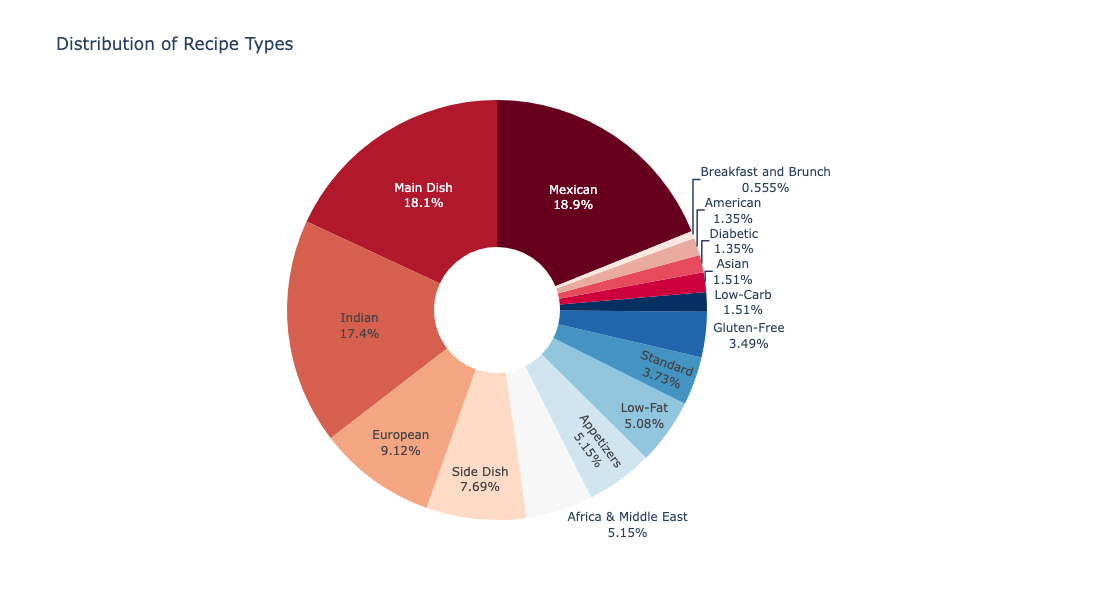

In [228]:
import plotly.express as px
import pandas as pd

type_counts = pd.DataFrame(recommended_recipes['Type'].value_counts())

# Plot an interactive pie chart
fig = px.pie(type_counts, names=type_counts.index, values='count', title='Distribution of Recipe Types',
             color_discrete_sequence=px.colors.sequential.RdBu, hole=0.3)

# Add some additional styling if needed
fig.update_traces(textinfo='percent+label')  
fig.update_layout(showlegend=False, width=800, height=600)

# Show the plot
fig.show()

In [243]:
listp = ['salt','carrots','water']
filtered_recipes = recommended_recipes[~recommended_recipes['Ingredients'].apply(lambda x: any(ingredient in x for ingredient in listp))].reset_index(drop=True)

list(np.unique(filtered_recipes.Type))

['Africa & Middle East',
 'American',
 'Appetizers',
 'Asian',
 'Breakfast and Brunch',
 'Diabetic',
 'European',
 'Gluten-Free',
 'Indian',
 'Low-Carb',
 'Low-Fat',
 'Main Dish',
 'Mexican',
 'Side Dish',
 'Standard']

## FP-growth

In [72]:
from mlxtend.frequent_patterns import fpgrowth, association_rules

frequent_itemsets_fp = fpgrowth(df_encoded, min_support=0.02, use_colnames=True)
print(len(frequent_itemsets_fp))
association_rules_fp = association_rules(frequent_itemsets_fp, metric="confidence", min_threshold=0.1)
association_rules_fp


298


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(allpurpose flour),(eggs),0.223047,0.273111,0.133547,0.598737,2.192282,0.072630,1.811502,0.699984
1,(eggs),(allpurpose flour),0.273111,0.223047,0.133547,0.488983,2.192282,0.072630,1.520404,0.748195
2,(allpurpose flour),(garlic),0.223047,0.285019,0.022919,0.102755,0.360521,-0.040653,0.796863,-0.695398
3,(black pepper),(allpurpose flour),0.228809,0.223047,0.033547,0.146614,0.657324,-0.017489,0.910436,-0.403339
4,(allpurpose flour),(black pepper),0.223047,0.228809,0.033547,0.150402,0.657324,-0.017489,0.907712,-0.401549
...,...,...,...,...,...,...,...,...,...,...
595,(cloves),(cinnamon),0.030090,0.100896,0.021639,0.719149,7.127606,0.018603,3.201354,0.886371
596,(allpurpose flour),(butter unsalted),0.223047,0.045711,0.023047,0.103330,2.260514,0.012852,1.064259,0.717705
597,(butter unsalted),(allpurpose flour),0.045711,0.223047,0.023047,0.504202,2.260514,0.012852,1.567074,0.584333
598,(butter unsalted),(eggs),0.045711,0.273111,0.022919,0.501401,1.835883,0.010435,1.457861,0.477112


In [75]:
def recommend_recipes(ingredients, rules):
    relevant_rules = rules[rules['antecedents'].apply(lambda x: set(ingredients).issubset(set(x)))]
    relevant_rules = relevant_rules.sort_values(by='confidence', ascending=False)
    print(len(relevant_rules['consequents']))
    
    top_rules = relevant_rules.iloc[0:3]
    recommended_ingredients = list(top_rules['consequents'])

    unique_ingredients = set()
    for item in recommended_ingredients:
        unique_ingredients.update(item)
    
    return list(unique_ingredients)

user_input_ingredients = ['cloves']

recommended_ingredients = recommend_recipes(user_input_ingredients, rules)


print('Recommended Ingredients:', recommended_ingredients)

1
Recommended Ingredients: ['cinnamon']


In [76]:
Ings  = list(recommended_ingredients) + user_input_ingredients

recommended_recipes = df[df['Ingredients'].apply(lambda x: all(ingredient in x for ingredient in Ings))]

recommended_recipes

,Title,Ingredients,Type
6,Diabetic Cranberry Sauce,"[orange juice, nutmeg, water, cinnamon, lemon,...",Diabetic
19,Carrot-Raisin Muffins,"[wheat germ, nutmeg, sugar substitute, carrots...",Diabetic
68,Apple Sauce Wheat Germ Cake,"[wheat germ, nutmeg, orange juice, sugar, baki...",Diabetic
90,Carrot Cake-Diabetic,"[nutmeg, water, baking powder, dates, raisins ...",Diabetic
92,Cherry Spice Cake,"[nutmeg, soy flour, milk, milk skim non fat po...",Diabetic
...,...,...,...
8783,Spiced Cider with Cranberries,"[nutmeg, crystallized ginger candied, oranges,...",Side Dish
8784,Spiced Pumpkin Soup,"[nutmeg, shallots, pumpkin, celery, cumin, cor...",Side Dish
9078,Ramsay's Roasted Butternut Squash Hummus,"[mustard seeds, garlic, buttercup squash, oliv...",Appetizers
9091,Simple Baklava Bites,"[sugar, apricots, honey, butter, bread crumbs,...",Appetizers


In [79]:
np.unique(recommended_recipes.Type,return_counts=True)

(array(['Africa & Middle East', 'American', 'Appetizers', 'Asian',
        'Breakfast and Brunch', 'Dessert', 'Diabetic', 'European',
        'Gluten-Free', 'Indian', 'Low-Fat', 'Main Dish', 'Mexican',
        'Side Dish', 'Standard'], dtype=object),
 array([18,  1,  3,  1, 14, 45,  8, 11,  1, 42,  1,  8, 12, 18,  6]))